In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [78]:
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import shutil
import torch
import torchvision.transforms as T

from aptos.data_loader import ImgProcessor, InplacePngTransforms

## PreProcess Images

In [3]:
DATA_DIR = Path('../data/raw')
# TRAIN_DIR = DATA_DIR / 'train_images'
TEST_DIR  = DATA_DIR / 'test_images'

In [5]:
# train_imgs = list(TRAIN_DIR.glob('*.png'))
test_imgs = list(TEST_DIR.glob('*.png'))
print(len(test_imgs))

1928


In [6]:
processor = ImgProcessor()

In [7]:
PROCESS_DIR = Path('../data/preprocessed')
# PRO_TRAIN_DIR = PROCESS_DIR / 'train_images'
PRO_TEST_DIR = PROCESS_DIR / 'test_images'

# PRO_TRAIN_DIR.mkdir(parents=True, exist_ok=True)
PRO_TEST_DIR.mkdir(parents=True, exist_ok=True)

In [12]:
def get_random_filename():
    return str(np.random.choice(test_imgs))

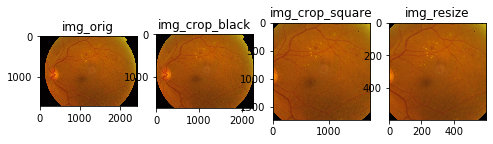

In [33]:
f = get_random_filename()
img_orig = processor.read_png(f)
img_crop_black = processor.crop_black(img_orig)
img_crop_square = processor.crop_square(img_crop_black)
img_resize = processor.resize(img_crop_square)

fig, axs = plt.subplots(1, 4, figsize=(8, 8))

axs[0].imshow(img_orig)
axs[0].set_title('img_orig')

axs[1].imshow(img_crop_black)
axs[1].set_title('img_crop_black')

axs[2].imshow(img_crop_square)
axs[2].set_title('img_crop_square')

axs[3].imshow(img_resize)
axs[3].set_title('img_resize')

plt.show()

  0%|          | 0/1928 [00:00<?, ?it/s]


IndexError: index 4 is out of bounds for axis 0 with size 4

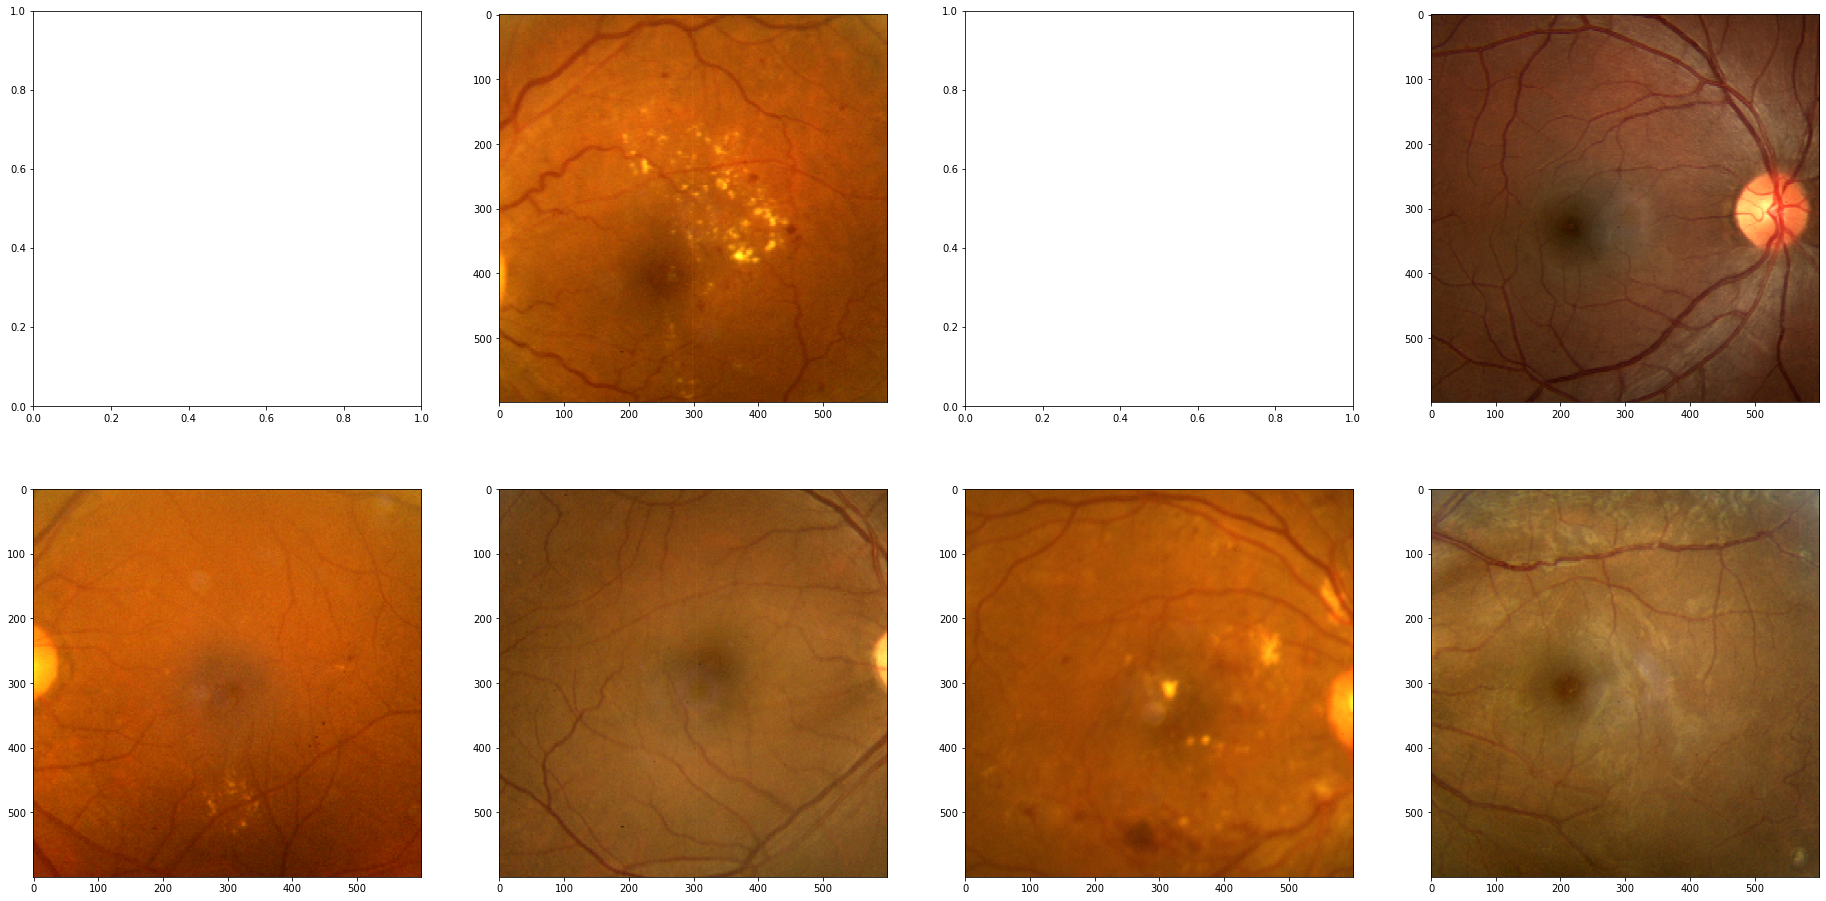

In [37]:
fig, axs = plt.subplots(2, 4, figsize=(32, 16))
nworkers = 4
with ThreadPoolExecutor(max_workers=nworkers) as executor:
    results = {executor.submit(processor, str(f)): idx for idx, f in enumerate(test_imgs[16:32])}
    for future in tqdm(as_completed(results), total=len(test_imgs)):
        img = future.result()
        idx = results[future]
        if idx < 4:
            axs[0][idx].imshow(img)
        else:
            axs[1][idx - 4].imshow(img)

## Copy the labels

In [39]:
def generator():
    for f in test_imgs:
        yield(processor(str(f)))
g = generator()

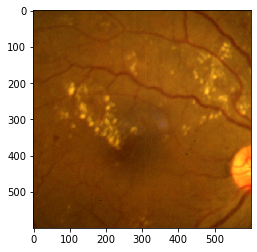

In [71]:
plt.imshow(g.__next__())

In [82]:
def generator():
    tsfm = InplacePngTransforms(True, 256)
    for f in test_imgs:
        yield(tsfm(str(f)))
g = generator()

def show(t):
    plt.imshow(T.ToPILImage()(t))

In [80]:
t = g.__next__()
t

tensor([[[-1.0466, -0.9513, -0.7923,  ..., -0.9830, -1.0148, -1.1102],
         [-1.0148, -0.8877, -0.8559,  ..., -1.1102, -1.1420, -1.1102],
         [-0.9195, -0.9195, -0.7288,  ..., -1.1102, -1.1102, -1.1102],
         ...,
         [ 0.3201,  0.2884,  0.1930,  ...,  0.0659,  0.2566,  0.2566],
         [ 0.3519,  0.3201,  0.1930,  ...,  0.0659,  0.3201,  0.4473],
         [ 0.3837,  0.3837,  0.3201,  ...,  0.0659,  0.2248,  0.4473]],

        [[-3.2335, -3.2335, -3.1148,  ..., -2.9962, -2.9170, -2.9170],
         [-3.2335, -3.2335, -3.1544,  ..., -3.2335, -3.1148, -2.9962],
         [-3.1148, -3.2335, -3.1544,  ..., -3.1544, -2.9962, -2.9566],
         ...,
         [-1.1767, -1.1767, -1.2953,  ..., -2.2051, -2.1260, -1.8886],
         [-1.2953, -1.0975, -1.2953,  ..., -2.0469, -2.0864, -1.8491],
         [-1.1371, -1.0975, -1.2558,  ..., -2.0864, -2.1260, -1.9282]],

        [[-7.8911, -7.8911, -7.7147,  ..., -7.6559, -7.7147, -7.8911],
         [-7.7147, -7.8323, -7.7147,  ..., -7

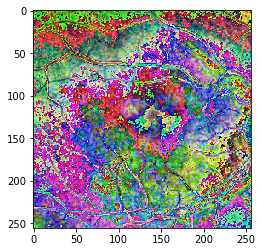

In [89]:
show(torch.rot90(t, 0, [1, 2]))

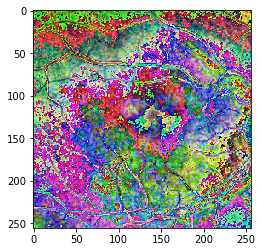

In [83]:
show(t)

In [92]:
t = torch.tensor(
[
    [1., 2., 3.],
    [4., 5., 6.]
])
t

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [94]:
t.mean(dim=1)

tensor([2., 5.])

In [95]:
t[:, 1]

tensor([2., 5.])

In [ ]:
train_csv = 'train.csv'
test_csv  = 'test.csv'

In [ ]:
shutil.copy(DATA_DIR / train_csv, PROCESS_DIR / train_csv)
shutil.copy(DATA_DIR / test_csv, PROCESS_DIR / test_csv)

## Check train/test examples

In [ ]:
pro_train_imgs = list(PRO_TRAIN_DIR.glob('*.npy'))
pro_test_imgs = list(PRO_TEST_DIR.glob('*.npy'))
print(len(pro_train_imgs), len(pro_test_imgs))

In [ ]:
n_samples = 10
figsize = 8

In [ ]:
np.random.shuffle(pro_train_imgs)
fig, axs = plt.subplots(2, n_samples // 2, figsize=(40, 16))
for i in range(n_samples // 2):
    train_img = np.load(str(pro_train_imgs[i]))
    axs[0, i].imshow(train_img)
for i in range(n_samples // 2, n_samples):
    train_img = np.load(str(pro_train_imgs[i]))
    axs[1, i - n_samples // 2].imshow(train_img)

## Processed image statistics

In [ ]:
nworkers = 4
means = np.zeros((len(pro_train_imgs), 3))
variances = np.zeros((len(pro_train_imgs), 3))
with ThreadPoolExecutor(max_workers=nworkers) as executor:
    results = {executor.submit(np.load, str(f)): f for f in pro_train_imgs}
    for future in tqdm(as_completed(results), total=len(pro_train_imgs)):
        img = future.result()
        f = results[future]
        idx = pro_train_imgs.index(f)
        means[idx, 0] = img[:, :, 0].mean()
        means[idx, 1] = img[:, :, 1].mean()
        means[idx, 2] = img[:, :, 2].mean()
        variances[idx, 0] = img[:, :, 0].std() ** 2
        variances[idx, 1] = img[:, :, 1].std() ** 2
        variances[idx, 2] = img[:, :, 2].std() ** 2

In [ ]:
print(means[:, 0].mean())
print(means[:, 1].mean())
print(means[:, 2].mean())

In [ ]:
print(math.sqrt(variances[:, 0].mean()))
print(math.sqrt(variances[:, 1].mean()))
print(math.sqrt(variances[:, 2].mean()))